In [19]:
from pathlib import Path
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 

import numpy as np
from petsc4py import PETSc
import matplotlib.pyplot as plt
import seaborn as sns


import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import petsc
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import meshtags
from dolfinx.fem.petsc import (
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc)

In [20]:
# Embankment properties
Load = 100 # load (kPa)
Base = 10 # embankment width (m)
 
nx = 100

name = ["Made ground", "Soft clay", "Firm clay"]
depths = [1, 2, 3, 5]
k = [2e-7,3e-7, 4e-7, 5e-7]    


T = (60*60*24) * 365 # final time (days)
time_steps = 100
dt = T / time_steps  

H = max(depths)
z = -np.linspace(0, H, nx, dtype= np.float64)# kept as small and not zero to prevent error



def Boussinesq(z):  # no input paramters required as this is only recalled under the same paramter each time
    """
    Boussinesq initial condition (strip load, centreline) for Terzaghi consolidation.
    Assumptions:
    - uniform embankment pressure q
    - embankment width B
    - 1D column at centreline
    - elastic stress distribution used only for initial condition
    """
    z = np.maximum(z,1e-12)
    u = (2.0 * Load / np.pi) * (np.arctan(Base / (2.0 * z)) + (Base * z) / (2.0 * z**2 + 0.5 * Base**2))
    return u


def uniform(z):
    u = np.full(z.shape[1], Load, dtype=np.float64)   # load everywhere
    u[np.isclose(z[0], 0.0)] = 0.0                    # top boundary x=0 -> 0
    return u


In [21]:
msh = mesh.create_interval(
    comm=MPI.COMM_WORLD,
    nx=nx,
    points=[0.0, H],
)

tdim = msh.topology.dim

msh.topology.create_connectivity(tdim, 0)
conn = msh.topology.connectivity(tdim, 0)

num_cells_local = msh.topology.index_map(tdim).size_local
cells = np.arange(num_cells_local, dtype= np.int32) 
cell_verts = conn.array.reshape(num_cells_local, 2)

x = msh.geometry.x[:,0] # only z dim 
midpoints = 0.5 * (x[cell_verts[:, 0]] + x[cell_verts[:, 1]])

cell_markers = np.zeros(num_cells_local, dtype=np.int32)
z_interface = [0.0] + depths
for i in range(len(k)):
    z0 = z_interface[i]
    z1 = z_interface[i+1]
    mask = (midpoints >= z0) & (midpoints < z1)  # returning on true bo0lean
    cell_markers[mask] = i + 1

# include bottom endpoint safely in last layer
cell_markers[midpoints >= z[-2]] = len(k)



DG0 = fem.functionspace(msh, ("DG", 0))
kappa = fem.Function(DG0)

for layerid, val in enumerate(k, start= 1):
    kappa.x.array[cell_markers == layerid] = val


kappa.x.scatter_forward()


In [22]:
V = fem.functionspace(msh, ("Lagrange", 1))

# Solution functions
u_n = fem.Function(V)

# Initial condition
u_n.interpolate(uniform)

fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim,
    marker=lambda x: np.isclose(x[0], 0.0)
)

dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V)

In [23]:
V = fem.functionspace(msh, ("Lagrange", 1))

# Solution functions
u_n = fem.Function(V)

initial_condition = lambda x: Boussinesq(x[0])

# Initial condition
u_n.interpolate(uniform)

fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim,
    marker=lambda x: np.isclose(x[0], 0.0)
)

dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V)


In [24]:
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(uniform)
# xdmf.write_function(uh,t)

# varational form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
 # PETSc make sure the background stuff doesnt explode
a = (u * v) * ufl.dx + dt * kappa  * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n) * v * ufl.dx
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form, bcs = [bc])
A.assemble()
b = petsc.create_vector(fem.extract_function_spaces(linear_form))


In [25]:
# creating linear solver 
solver = PETSc.KSP().create(msh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [26]:
u_hist = np.zeros((time_steps + 1, uh.x.array.size), dtype=float)
u_hist[0, :] = uh.x.array.copy()   # initial state
x = V.mesh.geometry.x[:, 0].copy()


for i in range(time_steps):
    with b.localForm() as loc_b:
        loc_b.set(0.0)
    assemble_vector(b, linear_form)

    apply_lifting(b ,[bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                  mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve
    solver.solve(b, uh.x.petsc_vec)

    # Update time-step solution
    u_n.x.array[:] = uh.x.array
    u_n.x.scatter_forward()

    u_hist[i + 1, :] = uh.x.array.copy()

# xdmf.close()
A.destroy()
b.destroy()
solver.destroy

u_hist

array([[  0.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [  0.        ,  11.60489378,  22.0695275 , ...,  99.9993022 ,
         99.99931841,  99.99932378],
       [  0.        ,   6.26284379,  12.44378663, ...,  99.99492379,
         99.99502588,  99.99505976],
       ...,
       [  0.        ,   0.4402985 ,   0.88048836, ...,  28.01714846,
         28.02752161,  28.03097961],
       [  0.        ,   0.4335507 ,   0.86699443, ...,  27.5878193 ,
         27.59803354,  27.60143856],
       [  0.        ,   0.42690638,   0.85370742, ...,  27.16506782,
         27.17512556,  27.17847842]], shape=(101, 101))

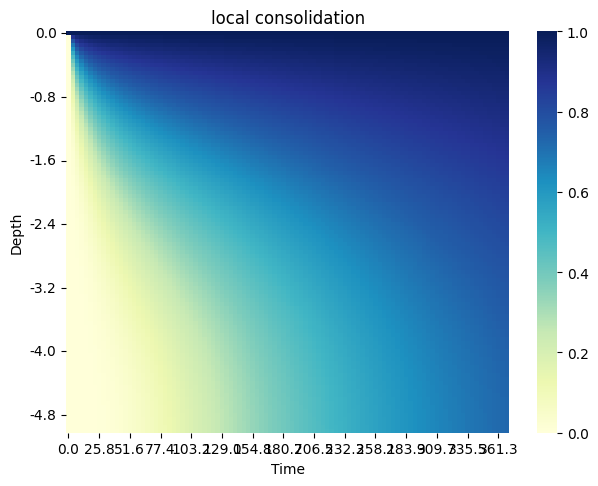

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

u_hist = pd.DataFrame(u_hist).T  # index is depth (y axis) and the column (x axis) is time_steps

u_hist
time = np.linspace(0,T,time_steps)/(60*60*24)
depth = np.linspace(0, -abs(H), nx)



kx = max(1, len(time)//13)    # ~8 labels across, auto
ky = max(1, len(depth)//6)  # ~10 labels down, auto 
local_dcons = 1 - (u_hist/ Load)

ax = sns.heatmap(local_dcons, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.title("local consolidation")
plt.show()
